In [8]:
import tensorflow as tf
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, InputLayer, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from src._logger import ProjectLogger
from datetime import datetime
import math
import traceback
from typing import Literal
import time

In [41]:
class RNNModel:
    logger = ProjectLogger(class_name='RNNModel').create_logger()
    thresholds = {
        'axialAxisRmsVibration': 0.1,
        'radialAxisKurtosis': 3,
        'radialAxisPeakAcceleration': 0.05,
        'radialAxisRmsAcceleration': 0.01
    }
    input_columns = ['axialAxisRmsVibration', 'radialAxisKurtosis', 'radialAxisPeakAcceleration', 'radialAxisRmsAcceleration', 'radialAxisRmsVibration', 'temperature']
    target_column = 'is_running'
    EPOCHS = 1

    def __init__(self):
        self.df = None
        self.input_steps = None
        self.output_steps = None
        self.window_size = None
        self.model_name = None
        self.model_directory_path = None
        self.train_size = 0.7   # percentage
        self.test_size = 0.2     # percentage
        self.start_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)


    def main(self, load_best_model:bool, df:pd.DataFrame, input_days:int, output_days:int, interval_minute:int, model_name:str=None):
        self.df = self.preprocess(df=df)
        """self.stats = self.calculate_stats(df=self.df, multiplier=3)
        self.window_size = math.floor(len(self.df) / 20)
        self.interval_minute = interval_minute
        self.model_name = model_name
        self.load_best_model = load_best_model

        # delete below if unnecessary
        self.input_steps = int((input_days - output_days) * 24 * (60 / interval_minute))
        self.output_steps = int(output_days * 24 * (60 / interval_minute))

        self.model_directory_path = os.path.join(os.getcwd(), 'models', f'{interval_minute}m')
        if not os.path.exists(self.model_directory_path):
            os.makedirs(self.model_directory_path)
        self.manage_model(job='select')     # select model, make predictions, save best model
        self.manage_model(job='delete')     # delete old models if len(model_files) > 5"""


    def load_existing_model_and_predict(self, model_name:str):
        try:
            lstm_model = tf.keras.models.load_model(f'{self.model_directory_path}/{model_name}')
            self.logger.info(msg=f'{model_name} named model successfully loaded!')
        except Exception as e:
            self.logger.error(msg=f'Exception happened while loading {model_name} named model!')
            self.logger.error(msg=traceback.format_exc())
            return None, None

        X, y = self.prepare_data(df=self.df, window_size=self.window_size)
        X_train, y_train, X_test, y_test, X_val, y_val = self.split_data(X=X, y=y, train_size=self.train_size, test_size=self.test_size)
        X_train_scaled, X_test_scaled, X_val_scaled, feature_scaler = self.scale_features(X_train=X_train, X_test=X_test, X_val=X_val)
        y_train_scaled, y_test_scaled, y_val_scaled, target_scaler = self.scale_targets(y_train=y_train, y_test=y_test, y_val=y_val)

        predictions = self.predict_future_values(X=X, model=lstm_model, output_steps=self.output_steps, feature_scaler=feature_scaler, target_scaler=target_scaler)
        timestamped_predictions = self.add_time_column_to_predicted_values(predictions=predictions, interval_minute=self.interval_minute)
        breakdown_probability = self.calculate_breakdown_probability(predictions=timestamped_predictions, column=self.target_column)
        results = self.calculate_model_performance(model=lstm_model, X_test_scaled=X_test_scaled, y_test=y_test, target_scaler=target_scaler)
        results['test_MSE'] = 0
        results['test_RMSE'] = 0
        results['breakdown_probability'] = breakdown_probability
        results['timestamp'] = datetime.now().replace(second=0, microsecond=0)
        results['model_name'] = str(self.model_name)
        results = self.convert_numpy_types(data=results)
        self.logger.info(msg=f'results:\n{results}')
        return results, timestamped_predictions


    def train_new_model_and_predict(self):
        X, y = self.prepare_data(df=self.df, window_size=self.window_size)
        X_train, y_train, X_test, y_test, X_val, y_val = self.split_data(X=X, y=y, train_size=self.train_size, test_size=self.test_size)
        X_train_scaled, X_test_scaled, X_val_scaled, feature_scaler = self.scale_features(X_train=X_train, X_test=X_test, X_val=X_val)
        y_train_scaled, y_test_scaled, y_val_scaled, target_scaler = self.scale_targets(y_train=y_train, y_test=y_test, y_val=y_val)

        lstm_model, test_MSE, test_RMSE = self.LSTM_Model(
            X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled, X_val_scaled=X_val_scaled,
            y_train_scaled=y_train_scaled, y_test_scaled=y_test_scaled, y_val_scaled=y_val_scaled)
        
        predictions = self.predict_future_values(X=X, model=lstm_model, output_steps=self.output_steps, feature_scaler=feature_scaler, target_scaler=target_scaler)
        timestamped_predictions = self.add_time_column_to_predicted_values(predictions=predictions, interval_minute=self.interval_minute)
        breakdown_probability = self.calculate_breakdown_probability(predictions=timestamped_predictions, column=self.target_column)
        results = self.calculate_model_performance(model=lstm_model, X_test_scaled=X_test_scaled, y_test=y_test, target_scaler=target_scaler)
        results['test_MSE'] = test_MSE
        results['test_RMSE'] = test_RMSE
        results['breakdown_probability'] = breakdown_probability
        results['timestamp'] = datetime.now().replace(second=0, microsecond=0)
        results['model_name'] = str(self.model_name)
        results = self.convert_numpy_types(data=results)
        self.logger.info(msg=f'results:\n{results}')
        return results, timestamped_predictions


    def preprocess(self, df):
        df.index = pd.to_datetime(df['time'], format='ISO8601')
        df.drop(inplace=True, axis=1, columns=['time', 'machine'])
        
        df = df[self.input_columns]
        df['is_running'] = 1
        df.loc[
            (df['axialAxisRmsVibration'] < self.thresholds['axialAxisRmsVibration']) & 
            (df['radialAxisKurtosis'] < self.thresholds['radialAxisKurtosis']) & 
            (df['radialAxisPeakAcceleration'] < self.thresholds['radialAxisPeakAcceleration']) & 
            (df['radialAxisRmsAcceleration'] < self.thresholds['radialAxisRmsAcceleration']),
            'is_running'
        ] = 0
        print(df['is_running'].value_counts())


        number_of_breakdowns = np.sum(df['axialAxisRmsVibration'] < self.thresholds['axialAxisRmsVibration'])
        print(f'number of breakdown at start: {number_of_breakdowns}')
        return df
    

    def calculate_stats(self, df, multiplier=6):
        #df = df[int(len(df) * 0.7):]
        #print(f'df length before: {len(df)}')
        stats = {}
        for column in df.columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - (multiplier * IQR)
            upper_bound = Q3 + (multiplier * IQR)

            #df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
            #df = df[(df[column] <= upper_bound)]
            stats[column] = {
                "mean": df[column].mean(),
                "std": df[column].std(),
                "min": df[column].min(),
                "max": df[column].max(),
                "upper": upper_bound,
                "lower": lower_bound
            }
        #    print(f'{column} - lower: {lower_bound} - upper: {upper_bound} - Q1: {Q1} - Q3: {Q3}')
        #print(stats)
        #print(f'df length after: {len(df)}')
        return stats


    def prepare_data(self, df:pd.DataFrame, window_size:int):
        target_index = df.columns.tolist().index(self.target_column)
        df = df.to_numpy()
        X = []
        y = []

        for index in range(len(df) - window_size):
            X.append([window for window in df[index:index + window_size]])
            y.append(df[index + window_size][target_index])
        return np.array(X), np.array(y)
    

    def split_data(self, X, y, train_size:float=0.7, test_size:float=0.2):
        if train_size + test_size > 1.0:
            self.logger.warning(msg='Train size and test size must sum up to 1 or less.')
            raise ValueError('Train size and test size must sum up to 1 or less.')
        
        train_size = int(len(X) * train_size)
        test_size = int(len(X) * test_size)
        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:train_size + test_size], y[train_size:train_size + test_size]
        X_val, y_val = X[train_size + test_size:], y[train_size + test_size:]
        return X_train, y_train, X_test, y_test, X_val, y_val
    

    def scale_features(self, X_train, X_test, X_val):
        feature_scaler = StandardScaler()
        X_train_scaled = feature_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
        X_val_scaled = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
        X_test_scaled = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
        return X_train_scaled, X_test_scaled, X_val_scaled, feature_scaler
    

    def scale_targets(self, y_train, y_val, y_test):
        target_scaler = StandardScaler()
        y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
        y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1))
        y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
        return y_train_scaled, y_test_scaled, y_val_scaled, target_scaler
    

    def LSTM_Model(self, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_val_scaled, y_val_scaled):
        lstm_model = Sequential()
        lstm_model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
        lstm_model.add(LSTM(100, return_sequences=True))
        lstm_model.add(Dropout(0.3))
        lstm_model.add(LSTM(50))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(8, 'relu'))
        lstm_model.add(Dense(1, 'linear'))
        lstm_model.summary()

        # @TODO:patience argument will be updated as 10
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        self.model_name = f'model_{int(time.time())}_{self.interval_minute}m.keras'
        checkpoint = ModelCheckpoint(f'{self.model_directory_path}/{self.model_name}', save_best_only=True)
        lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
        lstm_model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=self.EPOCHS, batch_size=32, callbacks=[checkpoint, early_stopping])
        test_MSE, test_RMSE = lstm_model.evaluate(X_test_scaled, y_test_scaled)
        return lstm_model, test_MSE, test_RMSE
    

    def predict_future_values(self, X, model, output_steps:int, feature_scaler, target_scaler):
        X_scaled = feature_scaler.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
        predictions = []
        last_sequence = X_scaled[-1]

        for _ in range(output_steps):
            pred = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))[0][0]
            predictions.append(pred)
            
            new_row = last_sequence[-1].copy()
            for col_idx, col_name in enumerate(self.df.columns):
                if col_name == self.target_column:
                    new_row[col_idx] = pred
                else:
                    #mean = self.stats[col_name]['mean']
                    #std = self.stats[col_name]['std']
                    #lower_bound = mean - std
                    #upper_bound = mean + std

                    mean = self.stats[col_name]['mean']
                    min_v = self.stats[col_name]['min']
                    max_v = self.stats[col_name]['max']
                    upper = self.stats[col_name]['upper']
                    std = self.stats[col_name]['std']
                    lower_bound = min_v
                    upper_bound = mean

                    new_row[col_idx] = np.random.uniform(lower_bound, upper_bound)
            last_sequence = np.vstack((last_sequence[1:], new_row))
        predictions_rescaled = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
        return predictions_rescaled
    

    def add_time_column_to_predicted_values(self, predictions, interval_minute):
        try:
            timestamps = pd.date_range(start=self.start_time, periods=len(predictions), freq=f'{interval_minute}min')
            timestamped_data = pd.DataFrame({
                'time': timestamps,
                'PredictedAxialAxisRmsVibration': predictions
            })
            print(f'\n------------------------\npredicted-data:\n{timestamped_data}')
        except Exception as e:
            self.logger.error(msg='Exception happened while adding time column to the predicted values!')
            self.logger.error(msg=traceback.format_exc())
        return timestamped_data
    

    def calculate_breakdown_probability(self, predictions, column:str):
        try:
            if isinstance(predictions, pd.DataFrame):
                predictions_column = predictions['PredictedAxialAxisRmsVibration']
            else:
                predictions_column = predictions

            #threshold = self.thresholds[column]
            threshold = 0.5
            number_of_breakdowns = np.sum(predictions_column < threshold)
            breakdown_probability = round(float((number_of_breakdowns * 100) / len(predictions_column)), 2)
            self.logger.info(msg=f'Breakdown probability calculated as {breakdown_probability}%')
            print(f'Num of breakdowns: {number_of_breakdowns}')
        except Exception as e:
            self.logger.error(msg=f'Exception happened while calculating breakdown probability!')
            self.logger.error(msg=traceback.format_exc())
        return breakdown_probability
    

    def calculate_model_performance(self, model, X_test_scaled, y_test, target_scaler):
        y_pred_scaled = model.predict(X_test_scaled, verbose=0)
        y_pred = target_scaler.inverse_transform(y_pred_scaled)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        r2 = r2_score(y_test, y_pred)
        metrics = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R2": r2}
        return metrics
    

    def convert_numpy_types(self, data):
        if isinstance(data, dict):
            return {key: self.convert_numpy_types(value) for key, value in data.items()}
        elif isinstance(data, list):
            return [self.convert_numpy_types(item) for item in data]
        elif isinstance(data, np.generic):
            return data.item()
        else:
            return data
        

    def manage_model(self, job:Literal['select', 'delete'], prefix='model_', max_models=5):
        if job not in ['select', 'delete']:
            raise ValueError(f'Invalid job type: {job}. jon must be "select" or "delete".')
        
        suffix = f'_{self.interval_minute}m.keras'
        model_files = [f for f in os.listdir(self.model_directory_path) if f.startswith(prefix) and f.endswith(suffix)]
        model_files.sort(key=lambda x: int(x.split(prefix)[1].split(suffix)[0]), reverse=True)

        if job == 'select':
            if self.load_best_model == True:
                if self.model_name is not None and self.model_name in model_files:
                    self.logger.info(msg=f'Selected model ({self.model_name}) will be used for predictions!')
                    return self.load_existing_model_and_predict(model_name=self.model_name)
                elif len(model_files) > 0:
                    self.model_name = model_files[0]
                    self.logger.info(msg=f'Latest model ({self.model_name}) will be used for predictions!')
                    return self.load_existing_model_and_predict(model_name=self.model_name)
                else:
                    self.logger.warning(msg=f'No saved model found! New model will be trained...')
                    return self.train_new_model_and_predict()
            else:
                self.logger.info(msg='New model will be trained...')
                return self.train_new_model_and_predict()
        elif job == 'delete':
            if len(model_files) > max_models:
                files_to_remove = model_files[5:]
                for f in files_to_remove:
                    os.remove(os.path.join(self.model_directory_path, f))
                self.logger.info(msg=f'Old models deleted! Deleted models: \n{files_to_remove}')



if __name__ == '__main__':
    df_15m = pd.read_csv('dataset/1724929644/dataset-90d.csv')[4::15]
    model = RNNModel()
    model.main(df=df_15m, input_days=90, output_days=10, interval_minute=15, load_best_model=False)

2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger 

2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger created successfully!
2024-12-13 02:08:21,357 - RNNModel - INFO - Logger 

is_running
1    7981
0     631
Name: count, dtype: int64
number of breakdown at start: 1176


In [17]:
class RNNModel:
    logger = ProjectLogger(class_name='RNNModel').create_logger()
    thresholds = {
        'axialAxisRmsVibration': 0.1,
        'radialAxisKurtosis': 3,
        'radialAxisPeakAcceleration': 0.05,
        'radialAxisRmsAcceleration': 0.01
    }
    input_columns = ['axialAxisRmsVibration', 'radialAxisKurtosis', 'radialAxisPeakAcceleration', 'radialAxisRmsAcceleration', 'radialAxisRmsVibration', 'temperature', 'is_running']
    target_column = 'axialAxisRmsVibration'

    def __init__(self):
        self.df = None
        self.input_steps = None
        self.output_steps = None
        self.window_size = None
        self.train_size = 0.7   # percentage
        self.test_size = 0.2     # percentage
        self.start_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        #self.target_index = self.input_columns.index('axialAxisRmsVibration')


    def main(self, df:pd.DataFrame, input_days:int, output_days:int, interval_minute:int):
        self.df = self.preprocess(df=df)
        self.stats = self.calculate_stats(df=self.df, multiplier=3)
        self.window_size = math.floor(len(self.df) / 20)
        self.interval_minute = interval_minute

        # delete below if unnecessary
        self.input_steps = int((input_days - output_days) * 24 * (60 / interval_minute))
        self.output_steps = int(output_days * 24 * (60 / interval_minute))
        

        X, y = self.prepare_data(df=self.df, window_size=self.window_size)
        X_train, y_train, X_test, y_test, X_val, y_val = self.split_data(X=X, y=y, train_size=self.train_size, test_size=self.test_size)
        X_train_scaled, X_test_scaled, X_val_scaled, feature_scaler = self.scale_features(X_train=X_train, X_test=X_test, X_val=X_val)
        y_train_scaled, y_test_scaled, y_val_scaled, target_scaler = self.scale_targets(y_train=y_train, y_test=y_test, y_val=y_val)

        lstm_model, lstm_loss = self.LSTM_Model(
            X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled, X_val_scaled=X_val_scaled,
            y_train_scaled=y_train_scaled, y_test_scaled=y_test_scaled, y_val_scaled=y_val_scaled)
        
        predictions = self.predict_future_values(X=X, model=lstm_model, output_steps=self.output_steps, feature_scaler=feature_scaler, target_scaler=target_scaler)
        timestamped_predictions = self.add_time_column_to_predicted_values(predictions=predictions, interval_minute=self.interval_minute)
        breakdown_probability = self.calculate_breakdown_probability(predictions=timestamped_predictions, column=self.target_column)
        results = self.calculate_model_performance(model=lstm_model, X_test_scaled=X_test_scaled, y_test=y_test, target_scaler=target_scaler)
        results['lstm_loss'] = lstm_loss
        results['breakdown_probability'] = breakdown_probability
        results['timestamp'] = datetime.now().replace(second=0, microsecond=0)

        self.plot_predictions(predictions=predictions, y_test=y_test)

        return results, timestamped_predictions


    def preprocess(self, df):
        self.input_columns.remove('is_running')      # @TODO: delete this line
        df = df[self.input_columns]
        df['is_running'] = 1
        df.loc[
            (df['axialAxisRmsVibration'] < self.thresholds['axialAxisRmsVibration']) & 
            (df['radialAxisKurtosis'] < self.thresholds['radialAxisKurtosis']) & 
            (df['radialAxisPeakAcceleration'] < self.thresholds['radialAxisPeakAcceleration']) & 
            (df['radialAxisRmsAcceleration'] < self.thresholds['radialAxisRmsAcceleration']),
            'is_running'
        ] = 0
        return df
    

    def calculate_stats(self, df, multiplier=3):
        stats = {}
        for column in df.columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - (multiplier * IQR)
            upper_bound = Q3 + (multiplier * IQR)

            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
            stats[column] = {
                "mean": df[column].mean(),
                "std": df[column].std()
            }
        return stats


    def prepare_data(self, df:pd.DataFrame, window_size:int):
        target_index = df.columns.tolist().index(self.target_column)
        df = df.to_numpy()
        X = []
        y = []

        for index in range(len(df) - window_size):
            X.append([window for window in df[index:index + window_size]])
            y.append(df[index + window_size][target_index])
        return np.array(X), np.array(y)
    

    def split_data(self, X, y, train_size:float=0.7, test_size:float=0.2):
        if train_size + test_size > 1.0:
            self.logger.warning(msg='Train size and test size must sum up to 1 or less.')
            raise ValueError('Train size and test size must sum up to 1 or less.')
        
        train_size = int(len(X) * train_size)
        test_size = int(len(X) * test_size)
        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:train_size + test_size], y[train_size:train_size + test_size]
        X_val, y_val = X[train_size + test_size:], y[train_size + test_size:]
        return X_train, y_train, X_test, y_test, X_val, y_val
    

    def scale_features(self, X_train, X_test, X_val):
        feature_scaler = StandardScaler()
        X_train_scaled = feature_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
        X_val_scaled = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
        X_test_scaled = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
        return X_train_scaled, X_test_scaled, X_val_scaled, feature_scaler
    

    def scale_targets(self, y_train, y_val, y_test):
        target_scaler = StandardScaler()
        y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
        y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1))
        y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
        return y_train_scaled, y_test_scaled, y_val_scaled, target_scaler
    

    def LSTM_Model(self, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_val_scaled, y_val_scaled):
        lstm_model = Sequential()
        lstm_model.add(LSTM(100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
        lstm_model.add(Dropout(0.3))
        lstm_model.add(LSTM(50))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(8, 'relu'))
        lstm_model.add(Dense(1, 'linear'))
        lstm_model.summary()

        # @TODO:patience argument will be updated as 10
        early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True) 
        checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
        lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
        lstm_model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=2, batch_size=32, callbacks=[checkpoint, early_stopping])
        lstm_loss = lstm_model.evaluate(X_test_scaled, y_test_scaled)
        return lstm_model, lstm_loss
    

    def predict_future_values(self, X, model, output_steps:int, feature_scaler, target_scaler):
        feature_scaler = StandardScaler()
        X_scaled = feature_scaler.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
        predictions = []
        last_sequence = X_scaled[-1]

        for _ in range(output_steps):
            pred = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))[0][0]
            predictions.append(pred)
            
            new_row = last_sequence[-1].copy()
            for col_idx, col_name in enumerate(self.df.columns):
                if col_name == self.target_column:
                    new_row[col_idx] = pred
                elif col_name == 'is_running':
                    new_row[col_idx] = 1 if pred > self.thresholds[self.target_column] else 0
                else:
                    mean = self.stats[col_name]['mean']
                    std = self.stats[col_name]['std']
                    lower_bound = mean - std
                    upper_bound = mean + std
                    new_row[col_idx] = np.random.uniform(lower_bound, upper_bound)
            last_sequence = np.vstack((last_sequence[1:], new_row))
        predictions_rescaled = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
        return predictions_rescaled
    

    def add_time_column_to_predicted_values(self, predictions, interval_minute):
        try:
            timestamps = pd.date_range(start=self.start_time, periods=len(predictions), freq=f'{interval_minute}min')
            timestamped_data = pd.DataFrame({
                'time': timestamps,
                'PredictedAxialAxisRmsVibration': predictions
            })
        except Exception as e:
            self.logger.error(msg='Exception happened while adding time column to the predicted values!')
            self.logger.error(msg=traceback.format_exc())
        return timestamped_data
    

    def calculate_breakdown_probability(self, predictions, column:str):
        try:
            if isinstance(predictions, pd.DataFrame):
                predictions_column = predictions['PredictedAxialAxisRmsVibration']
            else:
                predictions_column = predictions

            threshold = self.thresholds[column]
            number_of_breakdowns = np.sum(predictions_column < threshold)
            breakdown_probability = round(float((number_of_breakdowns * 100) / len(predictions_column)), 2)
            self.logger.info(msg=f'Breakdown probability calculated as {breakdown_probability}%')
        except Exception as e:
            self.logger.error(msg=f'Exception happened while calculating breakdown probability!')
            self.logger.error(msg=traceback.format_exc())
        return breakdown_probability
    

    def calculate_model_performance(self, model, X_test_scaled, y_test, target_scaler):
        y_pred_scaled = model.predict(X_test_scaled, verbose=0)
        y_pred = target_scaler.inverse_transform(y_pred_scaled)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        r2 = r2_score(y_test, y_pred)
        
        metrics = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R²": r2}
        self.logger.info(msg=f'metrics:\n{metrics}')
        return metrics
    

    def plot_predictions(self, predictions, y_test, start=0, end=960):
        df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y_test})
        plt.figure(figsize=(20, 12))
        plt.plot(df['Predictions'][start:end], label='Predictions', color='blue')
        plt.plot(df['Actuals'][start:end], label='Actuals', color='orange')
        plt.legend()
        plt.title('Predictions vs Actuals')
        plt.show()
    


if __name__ == '__main__':
    df = pd.read_csv('dataset/1724929644/dataset-90d.csv')
    df.index = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%SZ')
    df.drop(inplace=True, axis=1, columns=['time', 'machine'])
    df_15m = df[4::15]
    model = RNNModel()
    model.main(df=df_15m, input_days=90, output_days=10, interval_minute=15)

2024-12-10 09:29:53,950 - RNNModel - INFO - Logger created successfully!
2024-12-10 09:29:53,950 - RNNModel - INFO - Logger created successfully!
2024-12-10 09:29:53,950 - RNNModel - INFO - Logger created successfully!
2024-12-10 09:29:53,950 - RNNModel - INFO - Logger created successfully!
2024-12-10 09:29:53,950 - RNNModel - INFO - Logger created successfully!


c:\Users\yunus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 430, 100)       │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 430, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,817 (288.35 KB)

 Trainable params: 73,817 (288.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 56s 292ms/step - loss: 0.3824 - root_mean_squared_error: 0.6064 - val_loss: 0.3444 - val_root_mean_squared_error: 0.5869
Epoch 2/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - loss: 0.1678 - root_mean_squared_error: 0.4040 - val_loss: 0.3327 - val_root_mean_squared_error: 0.5768
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.1907 - root_mean_squared_error: 0.4349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━

2024-12-10 09:33:32,560 - RNNModel - INFO - Breakdown probability calculated as 0.0%
2024-12-10 09:33:32,560 - RNNModel - INFO - Breakdown probability calculated as 0.0%
2024-12-10 09:33:32,560 - RNNModel - INFO - Breakdown probability calculated as 0.0%
2024-12-10 09:33:32,560 - RNNModel - INFO - Breakdown probability calculated as 0.0%
2024-12-10 09:33:32,560 - RNNModel - INFO - Breakdown probability calculated as 0.0%
2024-12-10 09:33:37,864 - RNNModel - INFO - metrics:
{'MAE': 0.1000915433962654, 'MSE': 0.033329872320823864, 'RMSE': 0.18256470721589063, 'MAPE': 16.103119668830374, 'R²': 0.07329789176242152}
2024-12-10 09:33:37,864 - RNNModel - INFO - metrics:
{'MAE': 0.1000915433962654, 'MSE': 0.033329872320823864, 'RMSE': 0.18256470721589063, 'MAPE': 16.103119668830374, 'R²': 0.07329789176242152}
2024-12-10 09:33:37,864 - RNNModel - INFO - metrics:
{'MAE': 0.1000915433962654, 'MSE': 0.033329872320823864, 'RMSE': 0.18256470721589063, 'MAPE': 16.103119668830374, 'R²': 0.073297891762

ValueError: All arrays must be of the same length

c:\Users\yunus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2438 - val_loss: 0.0871
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0967 - val_loss: 0.0886
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0844 - val_loss: 0.0845
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0884 - val_loss: 0.0853
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0847 - val_loss: 0.0881
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0894 
Test Loss: 0.08000590652227402
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
acceleration - 25.83 - 14.34680908533082 - [15.92578401  0.79591837  0.3877551   0.40816327  1.        ]
temperature - 25.139 - 14.46010974279842 - [15.92578401  0.54065824 38.00087022  0.40816327  1.        ]
kurtosis - 25.925 - 14.490871621830081 - [15.92578401  0.54065824 38.00087022 32.78020326  1.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
acceleration - 25.83 - 14.34680908533082 - [36.81947857  0.54065824 38.00087022 32.78020326  1.        ]
tempe

C:\Users\yunus\AppData\Local\Temp\ipykernel_11136\168693859.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[col_idx] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
acceleration - 25.83 - 14.34680908533082 - [24.40261433 11.02670479 27.53723976 18.7694522   0.        ]
temperature - 25.139 - 14.46010974279842 - [24.40261433 14.5861969  38.37234339 18.7694522   0.        ]
kurtosis - 25.925 - 14.490871621830081 - [24.40261433 14.5861969  38.37234339 22.9988675   0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
acceleration - 25.83 - 14.34680908533082 - [35.58013756 14.5861969  38.37234339 22.9988675   0.        ]
temperature - 25.139 - 14.46010974279842 - [35.58013756 20.66114426 16.13152596 22.9988675   0.        ]
kurtosis - 25.925 - 14.490871621830081 - [35.58013756 20.66114426 16.13152596 30.92320587  0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
acceleration - 25.83 - 14.34680908533082 - [39.51705542 20.66114426 16.13152596 30.92320587  0.        ]
temperature - 25.139 - 14.46010974279842 - [39.51705542 18.99144745 13.6256611  30.92320587  0.        ]
kurtosis - 25.925 - 14.490871621830081 - [39.51705

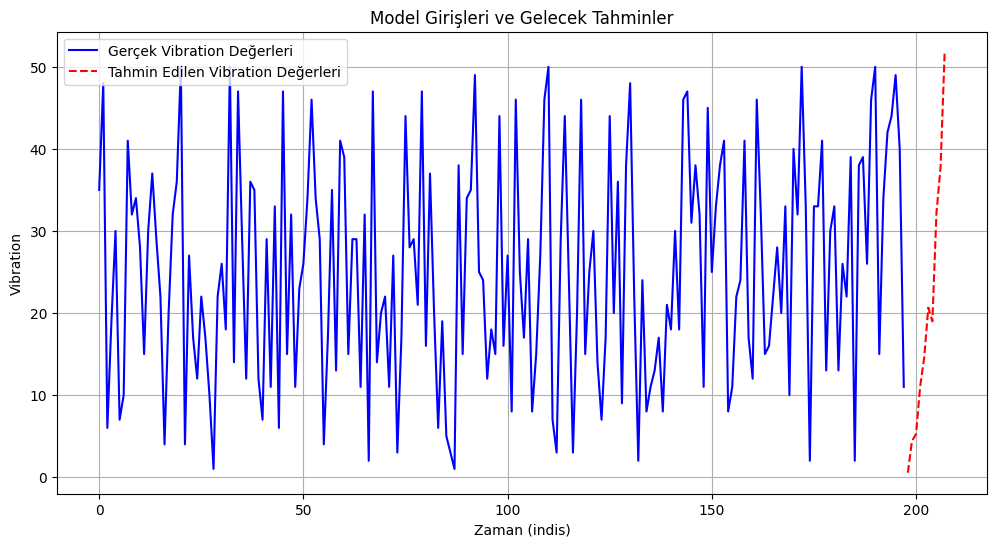

In [8]:


# 1. Rastgele Veri Oluşturma
np.random.seed(42)  # Tekrar edilebilirlik için
data = {
    'acceleration': np.random.randint(1, 51, 1000),
    'vibration': np.random.randint(1, 51, 1000),
    'temperature': np.random.randint(1, 51, 1000),
    'kurtosis': np.random.randint(1, 51, 1000),
    'is_running': np.random.choice([0, 1], 1000)
}

# Tarih ekleme (1 dakikalık aralıklarla)
dates = pd.date_range(start='2023-01-01 00:00:00', periods=1000, freq='T')
df = pd.DataFrame(data, index=dates)

# 2. Outlier Temizleme ve İstatistik Hesaplama Fonksiyonu
def remove_outliers_and_calculate_stats(df, multiplier=3):
    cleaned_df = df.copy()
    stats = {}
    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # 1. çeyrek
        Q3 = df[column].quantile(0.75)  # 3. çeyrek
        IQR = Q3 - Q1
        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)
        # Outlier'ları temizle
        cleaned_df = cleaned_df[(cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound)]
        # Ortalama ve Standart Sapma Hesapla
        stats[column] = {
            "mean": cleaned_df[column].mean(),
            "std": cleaned_df[column].std()
        }
    return stats

# 3. Outlier'ları temizle ve istatistikleri hesapla
stats = remove_outliers_and_calculate_stats(df)

# 4. Verileri Normalize Etme
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# 5. Zaman Serisi Verisini Hazırlama
sequence_length = 10
X = []
y = []

for i in range(len(scaled_df) - sequence_length):
    X.append(scaled_df.iloc[i:i+sequence_length].values)
    y.append(scaled_df['vibration'].iloc[i+sequence_length])

X = np.array(X)
y = np.array(y)

# Veri setini bölme
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42)

# 6. LSTM Modeli Oluşturma
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X.shape[2]), return_sequences=False),
    Dense(1)  # Çıkış: vibration tahmini
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# 7. Modeli Eğitme
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# 8. Modelin Performansını Değerlendirme
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# 9. Gelecek 10 'vibration' Tahmini ve Yeni Verilerle Güncelleme
future_predictions = []
last_sequence = X[-1]  # Son sekans

for _ in range(10):
    # Tahmin yap
    pred = model.predict(last_sequence.reshape(1, sequence_length, X.shape[2]))
    future_predictions.append(pred[0][0])
    
    # Yeni satırı oluştur
    new_row = last_sequence[-1].copy()  # Son satırın bir kopyasını alıyoruz
    
    for col_idx, col_name in enumerate(df.columns):
        if col_name == "vibration":
            # Vibration sütunu: Tahmin edilen değeri kullan
            new_row[col_idx] = pred
        elif col_name == 'is_running':
            new_row[col_idx] = random.choice([0, 1])
        else:
            # Diğer sütunlar için Ortalama ± Standart Sapma aralığında rastgele değer
            mean = stats[col_name]["mean"]
            std = stats[col_name]["std"]
            lower_bound = mean - std
            upper_bound = mean + std
            new_row[col_idx] = np.random.uniform(lower_bound, upper_bound)
            print(f'{col_name} - {mean} - {std} - {new_row}')
    
    # Yeni veriyi diziye ekle
    last_sequence = np.vstack((last_sequence[1:], new_row))  # Eski sekansı kaydır, yeni satırı ekle

# 10. Tahminleri ve Üretilen Değerleri Geri Ölçekleme
future_predictions_rescaled = scaler.inverse_transform(
    np.hstack((np.zeros((10, 4)), np.array(future_predictions).reshape(-1, 1)))
)[:, -1]

print("Gelecek 10 vibration tahmini:", future_predictions_rescaled)

# 11. Model Girişleri ve Tahminleri Çizme
def plot_predictions(y_true, y_pred, future_predictions_rescaled):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Gerçek Vibration Değerleri', color='blue')
    plt.plot(range(len(y_true), len(y_true) + len(future_predictions_rescaled)), future_predictions_rescaled, 
             label='Tahmin Edilen Vibration Değerleri', color='red', linestyle='--')
    plt.xlabel('Zaman (indis)')
    plt.ylabel('Vibration')
    plt.title('Model Girişleri ve Gelecek Tahminler')
    plt.legend()
    plt.grid()
    plt.show()

# Modelin girişleri ve tahmin edilen gelecekteki değerleri görselleştir
plot_predictions(df['vibration'][-len(y_test):].values, y_test, future_predictions_rescaled)
